In [6]:
using JLD2, FlavellBase, ImageDataIO, SegmentationTools, BehaviorDataNIR, HDF5, UNet2D, ProgressMeter, Random, Plots, NRRDIO, Statistics, StatsBase, PyPlot

┌ Warning: You are using a non-official build of Julia. This may cause issues with CUDA.jl.
│ Please consider using an official build from https://julialang.org/downloads/.
└ @ CUDA ~/.julia/packages/CUDA/75aiI/src/initialization.jl:180


WebIO._IJuliaInit()

### Pre-CropNet datasets

In [4]:
# Define base project directories
swf1212_dir = "/store1/shared/panneuralGFP_SWF1212/data_processed_220"
new_cam_prj_starv_dir = "/store1/candy/prj_starvation/data_processed"

# Create the dataset paths dictionary
dataset_paths = Dict(
    "2024-07-17-01" => swf1212_dir * "/2024-07-17-01_output/neuropal",
    "2024-07-17-06" => swf1212_dir * "/2024-07-17-06_output/neuropal",
    "2025-02-03-04" => new_cam_prj_starv_dir * "/2025-02-03-04_output/neuropal",
    "2025-02-06-01" => new_cam_prj_starv_dir * "/2025-02-06-01_output/neuropal",
    "2025-02-03-13" => swf1212_dir * "/2025-02-03-13_output/neuropal",
    "2025-02-10-01" => swf1212_dir * "/2025-02-10-01_output/neuropal",
    "2025-02-10-06" => swf1212_dir * "/2025-02-10-06_output/neuropal",
    "2025-02-18-01" => swf1212_dir * "/2025-02-18-01_output/neuropal",
    "2025-02-19-01" => swf1212_dir * "/2025-02-19-01_output/neuropal",
)

Dict{String, String} with 9 entries:
  "2025-02-18-01" => "/store1/shared/panneuralGFP_SWF1212/data_processed_220/20…
  "2025-02-19-01" => "/store1/shared/panneuralGFP_SWF1212/data_processed_220/20…
  "2025-02-03-04" => "/store1/candy/prj_starvation/data_processed/2025-02-03-04…
  "2024-07-17-01" => "/store1/shared/panneuralGFP_SWF1212/data_processed_220/20…
  "2024-07-17-06" => "/store1/shared/panneuralGFP_SWF1212/data_processed_220/20…
  "2025-02-06-01" => "/store1/candy/prj_starvation/data_processed/2025-02-06-01…
  "2025-02-03-13" => "/store1/shared/panneuralGFP_SWF1212/data_processed_220/20…
  "2025-02-10-01" => "/store1/shared/panneuralGFP_SWF1212/data_processed_220/20…
  "2025-02-10-06" => "/store1/shared/panneuralGFP_SWF1212/data_processed_220/20…

In [7]:
param_paths = Dict()
data_dicts = Dict()
cp_keys = ["dict_param_crop_rot", "head_pos"]
for dataset in keys(dataset_paths)
    rootpath = dataset_paths[dataset]
    all_immob = filter(isdir, readdir(rootpath, join=true))
    # print(all_immob, "\n")

    for subdir in all_immob
        path_data_dict = subdir * "/data_dict.jld2"
        path_param_path = subdir * "/param_path.jld2"
        # print(path_data_dict, "\n")
        if !isfile(path_data_dict) || !isfile(path_param_path)
            println("$(dataset) excluded: no data_dict or param_path")
            continue
        end
        f = JLD2.jldopen(path_data_dict)
        data_dict = f["data_dict"]
        close(f)
        data_uid = subdir[end-12:end]
        data_dicts[data_uid] = Dict()
    
        try
            for k in cp_keys
                data_dicts[data_uid][k] = data_dict[k]
            end
        catch e
            delete!(data_dicts, data_uid)
            println("$(dataset) excluded: $(e)")
        end

        f = JLD2.jldopen(path_param_path)
        param_paths[data_uid] = f["param_path"]
        close(f)
        add_get_basename!(param_paths[data_uid])
    end
end

2025-02-03-13 excluded: no data_dict or param_path


In [8]:
data_dicts

Dict{Any, Any} with 33 entries:
  "2025-02-19-05" => Dict{Any, Any}("head_pos"=>Dict{Any, Any}(5=>[250, 60], 56…
  "2025-02-10-05" => Dict{Any, Any}("head_pos"=>Dict{Any, Any}(5=>[35, 65], 56=…
  "2024-07-17-08" => Dict{Any, Any}("head_pos"=>Dict{Any, Any}(16=>[106, 120]),…
  "2025-02-06-05" => Dict{Any, Any}("head_pos"=>Dict{Any, Any}(5=>[204, 72], 56…
  "2025-02-18-04" => Dict{Any, Any}("head_pos"=>Dict{Any, Any}(5=>[232, 58], 56…
  "2024-07-17-03" => Dict{Any, Any}("head_pos"=>Dict{Any, Any}(5=>[61, 60], 7=>…
  "2024-07-17-07" => Dict{Any, Any}("head_pos"=>Dict{Any, Any}(5=>[40, 70], 56=…
  "2025-02-18-02" => Dict{Any, Any}("head_pos"=>Dict{Any, Any}(5=>[231, 72], 56…
  "2025-02-06-03" => Dict{Any, Any}("head_pos"=>Dict{Any, Any}(5=>[230, 50], 56…
  "2025-02-03-07" => Dict{Any, Any}("head_pos"=>Dict{Any, Any}(5=>[52, 51], 56=…
  "2024-07-17-10" => Dict{Any, Any}("head_pos"=>Dict{Any, Any}(5=>[123, 17], 56…
  "2025-02-06-04" => Dict{Any, Any}("head_pos"=>Dict{Any, Any}(5=>[224, 66], 

In [9]:
param_paths

Dict{Any, Any} with 33 entries:
  "2025-02-19-05" => Dict{String, Any}("path_dir_transformed_activity_marker"=>…
  "2025-02-10-05" => Dict{String, Any}("path_dir_transformed_activity_marker"=>…
  "2024-07-17-08" => Dict{String, Any}("path_dir_transformed_activity_marker"=>…
  "2025-02-06-05" => Dict{String, Any}("path_dir_transformed_activity_marker"=>…
  "2025-02-18-04" => Dict{String, Any}("path_dir_transformed_activity_marker"=>…
  "2024-07-17-03" => Dict{String, Any}("path_dir_transformed_activity_marker"=>…
  "2024-07-17-07" => Dict{String, Any}("path_dir_transformed_activity_marker"=>…
  "2025-02-18-02" => Dict{String, Any}("path_dir_transformed_activity_marker"=>…
  "2025-02-06-03" => Dict{String, Any}("path_dir_transformed_activity_marker"=>…
  "2025-02-03-07" => Dict{String, Any}("path_dir_transformed_activity_marker"=>…
  "2024-07-17-10" => Dict{String, Any}("path_dir_transformed_activity_marker"=>…
  "2025-02-06-04" => Dict{String, Any}("path_dir_transformed_activity_marker"

In [29]:
# JLD2.@save("/store1/candy/prj_unet2d/immob_data_dicts.jld2", data_dicts)
# JLD2.@save("/store1/candy/prj_unet2d/immob_param_paths.jld2", param_paths)

### Uncrop manual labels of head_pos, and visualize to confirm that it looks correct

In [10]:
function uncrop_single_point(dataset, param_paths, data_dicts, t; plot=false)

    path_nrrd = joinpath(param_paths[dataset]["path_dir_nrrd_crop"], param_paths[dataset]["get_basename"](t,2) * ".nrrd")
    img = read_img(NRRD(path_nrrd))
    img_crop = zeros(size(img))

    hp_1 = data_dicts[dataset]["head_pos"][t][1]
    hp_2 = data_dicts[dataset]["head_pos"][t][2]
    img_crop[hp_1:hp_1+1, hp_2:hp_2+1, 10:30] .= 1.0
    img_size = (322,210,77)
    img_uncrop = uncrop_img_roi(img_crop, data_dicts[dataset]["dict_param_crop_rot"][t], img_size)
    if plot
        imshow(maxprj(img_uncrop,dims=3))
    end
    hp = findall(x->x == 1.0, maxprj(img_uncrop,dims=3))[1]

    return hp
end

uncrop_single_point (generic function with 1 method)

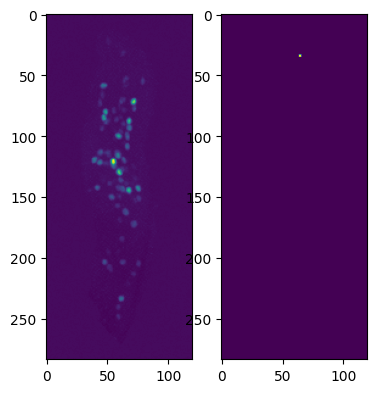

PyObject <matplotlib.image.AxesImage object at 0x7ad8f3090ca0>

In [15]:
let
    dataset = "2025-02-10-03"
    t = 30

    subplot(1,3,1)
    img_raw = read_img(NRRD(joinpath(param_paths[dataset]["path_dir_nrrd_crop"], param_paths[dataset]["get_basename"](t,2)*".nrrd")))
    imshow(maxprj(img_raw,dims=3))

    subplot(1,3,2)
    hp = data_dicts[dataset]["head_pos"][t]
    hp_1 = hp[1]
    hp_2 = hp[2]    
    img_crop = zeros(size(img_raw))
    img_crop[hp_1:hp_1+1, hp_2:hp_2+1, 10:30] .= 1.0
    imshow(maxprj(img_crop,dims=3))

    # subplot(1,3,3)
    # hp = uncrop_single_point(dataset, param_paths, data_dicts, t; plot=true)
    
    # print(hp)
end

### Take t=30

In [17]:
imgs_label = []
imgs_raw = []

for dataset in keys(data_dicts) # per immob recording
    t = 30
    img_raw = nothing
    img_label = nothing
    head_pt = nothing
    
    try
        img_raw = read_img(NRRD(joinpath(param_paths[dataset]["path_dir_nrrd_crop"], param_paths[dataset]["get_basename"](t,2)*".nrrd")))     
        head_pt = data_dicts[dataset]["head_pos"][t]

        img_raw = maxprj(img_raw,dims=3)
        img_label = zeros(Bool, size(img_raw))
        img_label[[x for x in CartesianIndices(size(img_label)) if euclidean_dist(Tuple(x),Tuple(head_pt)) < 25]] .= 1
        push!(imgs_label, img_label)
        push!(imgs_raw, img_raw)
        
    catch e
        continue
    end

end

In [18]:
imgs_raw

30-element Vector{Any}:
 UInt16[0x00ee 0x00ee … 0x00f4 0x00ee; 0x00f0 0x00f3 … 0x00f1 0x00e9; … ; 0x00ef 0x00f1 … 0x00eb 0x00f3; 0x00e7 0x00ed … 0x00eb 0x00ed]
 UInt16[0x0093 0x0090 … 0x0094 0x0095; 0x008f 0x0090 … 0x0088 0x0096; … ; 0x0090 0x0094 … 0x008d 0x0096; 0x0091 0x0093 … 0x0092 0x008c]
 UInt16[0x0101 0x010a … 0x0106 0x00ff; 0x0102 0x0104 … 0x0105 0x0102; … ; 0x0108 0x0100 … 0x0107 0x010a; 0x00f9 0x010c … 0x0109 0x0108]
 UInt16[0x004e 0x0043 … 0x0040 0x0046; 0x0048 0x0049 … 0x003e 0x0043; … ; 0x0042 0x004c … 0x0041 0x0044; 0x004c 0x004b … 0x0049 0x0042]
 UInt16[0x0134 0x0130 … 0x0131 0x0138; 0x0137 0x0138 … 0x0133 0x0134; … ; 0x0131 0x012e … 0x012b 0x0137; 0x0130 0x0138 … 0x0135 0x0133]
 UInt16[0x0090 0x0097 … 0x0092 0x0092; 0x0098 0x008e … 0x0088 0x0093; … ; 0x0093 0x0091 … 0x0092 0x0091; 0x0094 0x008c … 0x0092 0x0090]
 UInt16[0x0498 0x0493 … 0x047f 0x04a4; 0x046e 0x04b6 … 0x049b 0x0469; … ; 0x048b 0x0484 … 0x04ab 0x04b3; 0x0484 0x04ab … 0x048a 0x04b0]
 UInt16[0x00b1 0x00a0 … 

In [19]:
imgs_label 

30-element Vector{Any}:
 Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
 Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
 Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
 Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
 Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
 Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
 Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
 Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
 Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
 Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
 Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
 Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
 Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
 ⋮
 Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
 Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
 Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
 Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
 Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
 

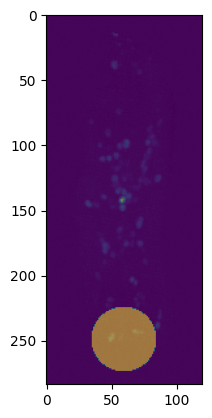

PyObject <matplotlib.image.AxesImage object at 0x7ad8e1d58220>

In [20]:
let
    i = 1
    img = imgs_raw[i]
    lbl = imgs_label[i]

    imshow(img)
    imshow(lbl, alpha=0.5)
end

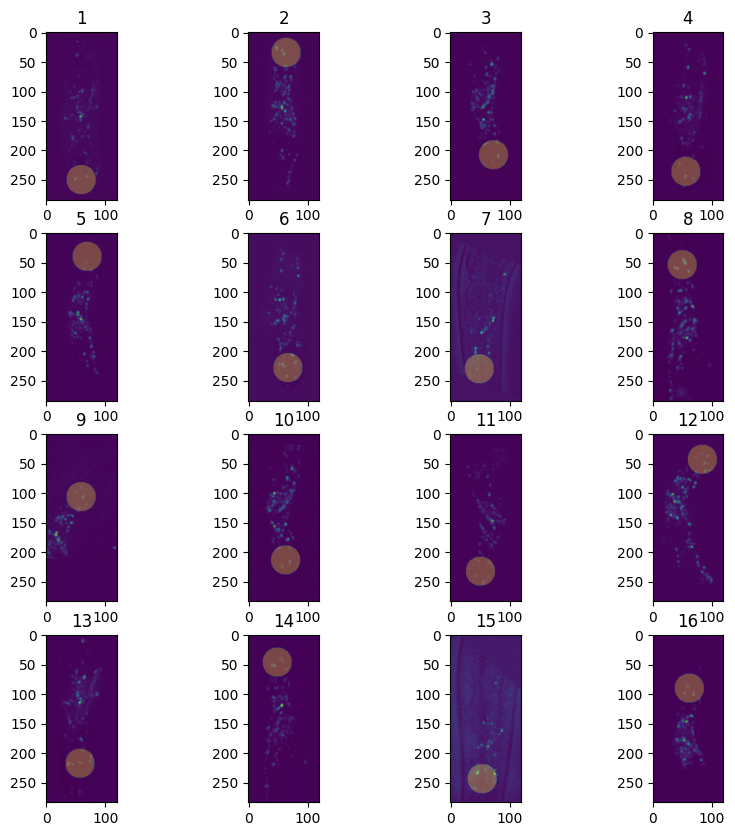

In [28]:
# Some of the immobilized head_pos is wrong, so manually check each of them on a 4x4 grid plot
figure(figsize=(10,10))

# Loop through images 1-16
for (idx,i) in enumerate(collect(1:16))
    # Select the subplot
    subplot(4,4,idx)
    
    # Get image and label for current index
    img = imgs_raw[i]
    lbl = imgs_label[i]
    
    # Plot the image
    imshow(img)
    imshow(lbl, alpha=0.3)
    title("$(i)")
end

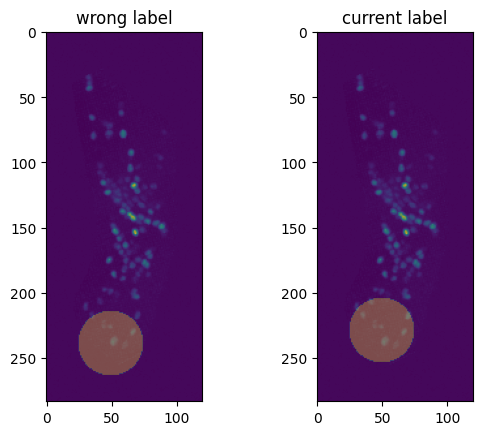

PyObject Text(0.5, 1.0, 'current label')

In [26]:
# manually correct any wrong labels
let
    i = 21 # load in each of the wrong ones
    img_raw = imgs_raw[i]
    wrong_lbl = imgs_label[i]
    subplot(1,2,1)
    imshow(img_raw)
    imshow(wrong_lbl, alpha=0.3)
    title("wrong label")
    
    head_pt = [230, 50]
    img_label = zeros(Bool, size(img_raw))
    img_label[[x for x in CartesianIndices(size(img_label)) if euclidean_dist(Tuple(x),Tuple(head_pt)) < 25]] .= 1
    imgs_label[i] = img_label
    subplot(1,2,2)
    imshow(imgs_raw[i])
    imshow(imgs_label[i], alpha=0.3)
    title("current label")
end

In [29]:
### write into h5
path_new_h5 = "/store1/candy/prj_unet2d/data/immob_postCropNet.h5"

h5open(path_new_h5, "w") do f
    for i=1:length(imgs_label)
        d = "$(i)"
        create_group(f, d)
        f[d]["img"] = UInt16.(imgs_raw[i])
        f[d]["label"] = imgs_label[i]
    end
end